In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh

import konlpy
from konlpy.tag import Okt
from konlpy.tag import Mecab

okt = Okt()
mecab = Mecab()

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91 (from 1)
Receiving objects: 100% (138/138), 1.72 MiB | 23.73 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Mecab-ko-for-Google-Colab/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2024-12-22 07:22:37--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.142.24, 104.192.142.26, 104.192.142.25, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.142.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # 구글 드라이브 연결

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터 가져오기
review = pd.read_csv('/content/drive/MyDrive/labeling_data1.csv', encoding='utf-8')

# 중복 제거
review.drop_duplicates(subset=['title'], inplace=True)

# NULL 값 제거
review = review.dropna(how='any')

# 한글, 공백, 숫자(특수문자 사이에 있는 숫자는 제거) 제외하고 모두 제거
review['title'] = review['title'].apply(lambda x: re.sub(r'(?<=\W)\d+(?=\W)|[^\wㄱ-ㅎㅏ-ㅣ가-힣\s]', "", x))

print(review['title'])

0                    키스타임사직야구장 롯데자이언츠응원 shortsvideo 롯데자이언츠
1                                      이제 외국에서 한국말 함부로 못해요
2             1000만뷰1박2일 내내 쏟아지는 폭우 속 우중캠핑  새 화로대 개시했어요   
3        1000만뷰하루종일 비 내리는 날 경차로 여름휴가 떠나기  개별화장실 계곡 앞 신생...
4                                 도저히 못 들어갈 갠지스강 바닥에 쌓인 것들
                               ...                        
14554                      눈 내리는 궁궐   어디일까요    마음에 들면 두번터치
14555     외국인 여자친구 만나러 2개월만에 태국 방콕으로 국제커플 International...
14556                             아직도 이해하기 힘든 일본버스 요금정산 방식
14557    캠핑카세계여행 캠핑장으로 가는 길들이 다 막혀버렸다  영국에서 캠핑장 찾아 삼만리 ...
14558    아름다운 폭포와 계곡이 있는 동해시 무릉계곡 추천해드립니다 여기는 올 여름에 꼭 다...
Name: title, Length: 13538, dtype: object


<ipython-input-72-9bc0afb7d2c7>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="Blues_d")


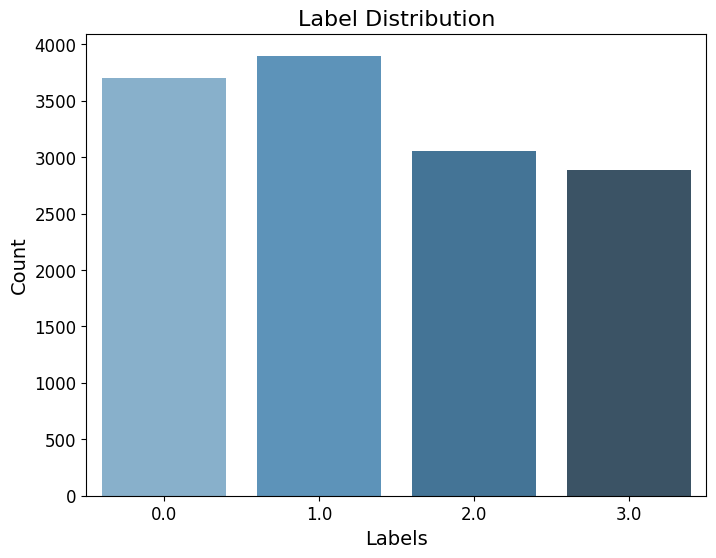

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 라벨 분포 계산
label_counts = review['label'].value_counts().sort_index()  # 라벨별 개수 계산 및 정렬

# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Blues_d")
plt.title("Label Distribution", fontsize=16)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [ ]:
# POS 태깅
def tokenize_and_pos_tagging(text):
    if not isinstance(text, str):
        return []

    # 예외 단어 리스트
    exceptions = [
        '동남아', '여사친', '호캉스', '관종', '천원', '오랜만', '갬성', '고기',
        '도미토리', '가성비', '마피랭패스', '로바다야키', '방센비치', '코시창',
        '이케시마', '극강', '엘칼라파테', '엘찰텐', '푸에르토', '나탈레스',
        '아카타마', '우유니', '잔지바르', '마데이라', '몬테네그로', '푸바오'
    ]

    # 예외 단어를 먼저 찾아 'Noun'으로 태깅
    exceptions_pattern = '|'.join(map(re.escape, exceptions))
    matches = re.finditer(exceptions_pattern, text)

    result = []
    last_index = 0

    for match in matches:
        # 예외 단어 이전의 텍스트를 분석
        if match.start() > last_index:
            result.extend(okt.pos(text[last_index:match.start()]))

        # 예외 단어 태깅
        result.append((match.group(), 'Noun'))
        last_index = match.end()

    # 남은 텍스트 분석
    if last_index < len(text):
        result.extend(okt.pos(text[last_index:]))

    return result

# 필요한 품사(명사, 동사, 형용사, 숫자, 부사)를 제외한 나머지 품사들은 삭제
def extract(pos_tags):
  return [word for word, tag in pos_tags if tag in ['Noun','Verb','Adjective','Number','Adverb']]

# POS 태깅 적용
review['title'] = review['title'].apply(tokenize_and_pos_tagging)

print(review['title'][74])

# 불필요한 품사 제거
review['title'] = review['title'].apply(extract)

review = review[review['title'].apply(len) > 0].reset_index(drop=True)

print(review['title'])

[('시골', 'Noun'), ('에서', 'Josa'), ('미혼', 'Noun'), ('여자', 'Noun'), ('혼자', 'Noun'), ('살', 'Noun'), ('면', 'Josa'), ('생기는', 'Verb'), ('일', 'Noun')]
0                    [키스타임, 사직야구장, 롯데, 자이언츠, 응원, 롯데, 자이언츠]
1                                   [이제, 외국, 한국말, 함부로, 해요]
2        [1000만, 1, 박, 2일, 내내, 쏟아지는, 폭우, 속, 우중, 캠핑, 새, ...
3        [1000만, 비, 내리는, 날, 경차, 여름, 휴가, 떠나기, 개별, 화장실, 계...
4                           [도저히, 못, 들어갈, 갠지스강, 바닥, 쌓인, 것]
                               ...                        
13529               [눈, 내리는, 궁궐, 어디, 일까, 요, 마음, 들면, 번, 터치]
13530              [외국인, 여자친구, 만나러, 2, 개월, 태국, 방콕, 국제, 커플]
13531                   [아직도, 이해, 하기, 힘든, 일본, 버스, 금정산, 방식]
13532    [캠핑카, 세계, 여행, 캠핑장, 가는, 길들이, 다, 막혀, 버렸다, 영국, 캠핑...
13533    [아름다운, 폭포, 계곡, 있는, 동해시, 무릉, 계곡, 추천, 해드립니다, 여기는...
Name: title, Length: 13534, dtype: object


In [ ]:
df = pd.DataFrame(review)

df.to_csv('/content/drive/MyDrive/labeling_data_okt.csv', index=False)
print(df['label'].unique())  # 라벨 값 종류 확인
print(df['label'].value_counts())  # 라벨 값 분포 확인

[3. 2. 1. 0.]
label
1.0    3898
0.0    3696
2.0    3055
3.0    2885
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

# 라벨 인코딩 (숫자로 변환)
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])


# 자체 임베딩


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Input, Embedding, Dense, Dropout, Flatten, LayerNormalization, concatenate
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec# 자체 word2vec 모델 학습
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
scaler = StandardScaler()


In [ ]:
# 2. word2vec 모델 학습
word2vec_model = Word2Vec(sentences=review['title'], vector_size=100, window=5, min_count=1, workers=4)

# 2.각 단어를 word2Vec 벡터로 변환하는 함수 정의
def get_word_index(word, model):
  if word in model.wv:
    return model.wv.key_to_index[word] + 1 # keras Embedding 레이어는 인덱스가 1부터 시작해야 함
  return 0 # 없는 단어는 0으로 패딩

# 각 리뷰를 정수 인덱스 시퀀스로 변환
review['title'] = review['title'].apply(
    lambda tokens: [get_word_index(word, word2vec_model) for word in tokens]
)

review['title']

,title
0,"[2048, 815, 359, 507, 877, 359, 507]"
1,"[416, 319, 961, 2174, 3969]"
2,"[5179, 11, 28, 163, 4659, 1639, 681, 76, 328, ..."
3,"[5179, 217, 716, 109, 2958, 124, 475, 1508, 47..."
4,"[5042, 271, 8887, 3907, 1897, 4686, 108]"
...,...
13529,"[374, 716, 2844, 67, 74, 64, 78, 105, 40, 70]"
13530,"[309, 176, 1138, 14, 525, 4, 122, 497, 432]"
13531,"[1494, 1668, 52, 411, 21, 239, 8729, 4448]"
13532,"[111, 2, 1, 127, 132, 14767, 125, 5675, 2188, ..."


In [ ]:
max_seq = review['title'].apply(len).max()
print(f"가장 긴 타이틀의 시퀀스 길이: {max_seq}")

가장 긴 타이틀의 시퀀스 길이: 37


In [ ]:
max_len = 38 # 각 리뷰의 최대 길이 (단어 수)
# 패딩 처리하여 모든 리뷰의 길이를 동일하게 맞춤
# 리뷰 제목 (임베딩 기반)과 구독자 수 정규화, 패딩'post'는 LSRM을 위해 오른쪽 패딩
X_title = pad_sequences(review['title'], maxlen=max_len, padding='post')  # 제목 -> 정수 시퀀스 -> 패딩
X_subs = scaler.fit_transform(np.array(review['subscribers']).reshape(-1, 1))  # 구독자 수 정규화
y = review['label'].astype(int).values  # 기존의 label 열을 정수형으로 변환

# 원-핫 인코딩 (분류 문제용 라벨)
y_onehot = to_categorical(y)


# 학습/테스트 데이터 분리
X_title_train, X_title_test, X_subs_train, X_subs_test, y_train, y_test = train_test_split(
    X_title, X_subs, y_onehot, test_size=0.2, stratify=y_onehot
)

# LSTM 모델 설계
vocab_size = len(word2vec_model.wv) + 1 # 단어 집합 크기(+1은 패딩을 위한 공간)
embedding_dim = word2vec_model.vector_size

# Wor2Vec 기반 임베딩 행렬 생성
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word2vec_model.wv.key_to_index.items():
  embedding_matrix[idx + 1] = word2vec_model.wv[word] # 인덱스는 1부터 시작

In [ ]:
# 라벨 개수 확인
num_classes = y_onehot.shape[1]

In [ ]:
# 2. 모델 구성
# 분류 모델
def build_classification_model(vocab_size, embedding_dim, max_len, num_classes):
    # 제목 입력
    title_input = Input(shape=(max_len,), name="Title_Input")
    title_embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        mask_zero=True,
        trainable=True
    )(title_input)

   # GRU 계층
    title_gru = LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01), use_cudnn=False)(title_embedding)
    title_gru = BatchNormalization()(title_gru)
    title_gru = Dropout(0.5)(title_gru)
    #title_gru = Bidirectional(LSTM(64, return_sequences=False))(title_gru)
    #title_gru = BatchNormalization()(title_gru)
    #title_gru = Dropout(0.4)(title_gru)

    # 구독자 수 입력
    subscribers_input = Input(shape=(1,), name="Subscribers_Input")

    # 입력 병합
    merged = concatenate([Dense(5, activation='leaky_relu', kernel_regularizer=l2(0.01))(subscribers_input), title_gru])

    # Dense 레이어
    dense = Dense(32, activation="leaky_relu", kernel_regularizer=l2(0.01))(merged)
    dense = Dropout(0.5)(dense)
    #dense = Dense(16, activation="leaky_relu")(merged)
    #dense = Dropout(0.5)(dense)
    output = Dense(num_classes, activation="softmax")(dense)  # 출력층: 분류 (소프트맥스)

    # 모델 정의
    model = Model(inputs=[title_input, subscribers_input], outputs=output)
    return model

# 모델 생성
model = build_classification_model(vocab_size, embedding_dim, max_len, num_classes)

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 콜백 정의
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# 클래스 가중치 적용
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

# 모델 학습
history = model.fit(
    [X_title_train, X_subs_train], y_train,
    validation_data=([X_title_test, X_subs_test], y_test),
    epochs=100, batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# 모델 평가
loss, accuracy = model.evaluate([X_title_test, X_subs_test], y_test)
print(f"테스트 손실: {loss:.4f}, 테스트 정확도: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.2544 - loss: 4.2018 - val_accuracy: 0.3288 - val_loss: 3.2923
Epoch 2/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.2847 - loss: 3.5701 - val_accuracy: 0.3761 - val_loss: 3.0261
Epoch 3/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3140 - loss: 3.1773 - val_accuracy: 0.3942 - val_loss: 2.8044
Epoch 4/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3393 - loss: 2.9194 - val_accuracy: 0.3964 - val_loss: 2.6126
Epoch 5/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3518 - loss: 2.6763 - val_accuracy: 0.3967 - val_loss: 2.4478
Epoch 6/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3940 - loss: 2.4574 - val_accuracy: 0.4252 - val_loss: 2.3101
Epoch 7/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4204 - loss: 2.2996 - val_accuracy: 0.4466 - val_loss: 2.1801
Epoch 8/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4815 - loss: 2.1301 - va

# 검증


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict([X_title_test, X_subs_test])
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

print(confusion_matrix(y_true_classes, y_pred_classes))
print(classification_report(y_true_classes, y_pred_classes))


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
[[345 286  54  54]
 [226 385  80  89]
 [113 230 132 136]
 [ 75 104  62 336]]
              precision    recall  f1-score   support

           0       0.45      0.47      0.46       739
           1       0.38      0.49      0.43       780
           2       0.40      0.22      0.28       611
           3       0.55      0.58      0.56       577

    accuracy                           0.44      2707
   macro avg       0.45      0.44      0.43      2707
weighted avg       0.44      0.44      0.43      2707



85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


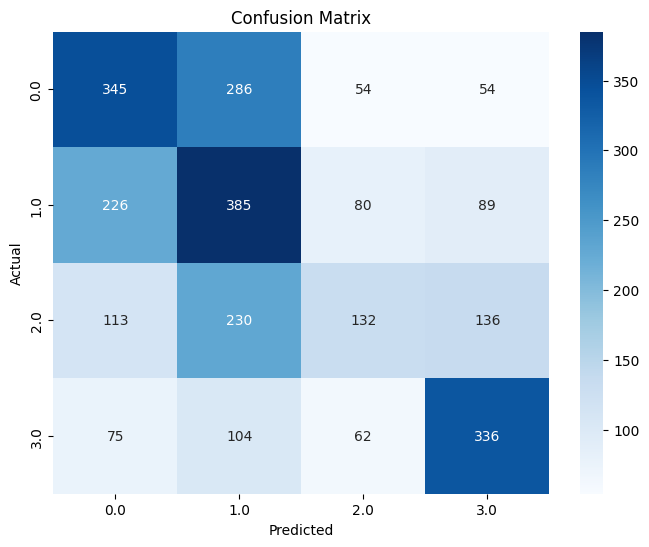

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 예측값과 실제값
y_pred = model.predict([X_title_test, X_subs_test])
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

# 혼동행렬
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

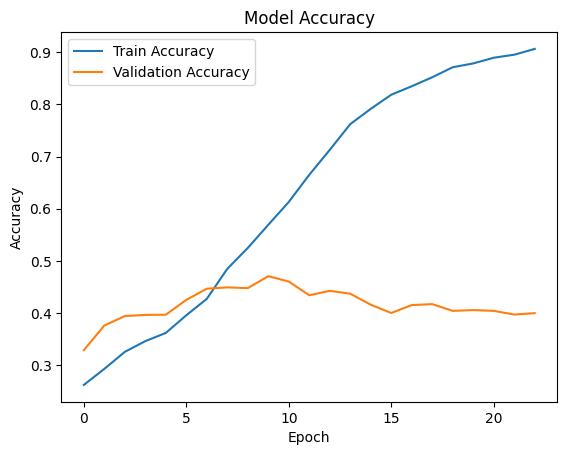

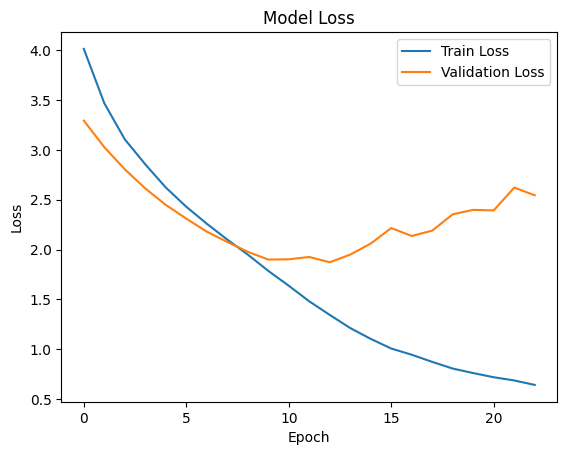

In [ ]:
import matplotlib.pyplot as plt

# 학습 정확도 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 학습 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_views(title, subscribers, model, word2vec_model, max_len):
    # 제목 토큰화
    title_tokens = okt.morphs(title)
    title_indices = [word2vec_model.wv.key_to_index[word] + 1 if word in word2vec_model.wv else 0 for word in title_tokens]

    # 제목 패딩 처리
    title_padded = pad_sequences([title_indices], maxlen=max_len, padding='post')

    # 구독자 수 정규화
    subscribers_scaled = scaler.transform([[subscribers]])

    # 예측 수행
    prediction = model.predict([title_padded, subscribers_scaled])
    predicted_views = prediction.argmax(axis=1)[0]

    return predicted_views

# 예시 입력
title_input = "한국인 관광객을 건드린 시리아인의 최후 Koreli turisti taciz eden suriyelilerin sonu #shorts" # - 3
subscribers_input = 456000 # 구독자 수

# 예측 조회수 출력
predicted_views = predict_views(title_input, subscribers_input, model, word2vec_model, max_len)
print(f"제목: {title_input}")
print(f"구독자 수: {subscribers_input}")
print("실제 조회수 범위: 3")
print(f"예측 조회수 범위: {predicted_views}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
제목: 한국인 관광객을 건드린 시리아인의 최후 Koreli turisti taciz eden suriyelilerin sonu #shorts
구독자 수: 456000
실제 조회수 범위: 3
예측 조회수 범위: 3


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_views(title, subscribers, model, word2vec_model, max_len):
    # 제목 토큰화
    title_tokens = okt.morphs(title)
    title_indices = [word2vec_model.wv.key_to_index[word] + 1 if word in word2vec_model.wv else 0 for word in title_tokens]

    # 제목 패딩 처리
    title_padded = pad_sequences([title_indices], maxlen=max_len, padding='post')

    # 구독자 수 정규화
    subscribers_scaled = scaler.transform([[subscribers]])

    # 예측 수행
    prediction = model.predict([title_padded, subscribers_scaled])
    predicted_views = prediction.argmax(axis=1)[0]

    return predicted_views

# 예시 입력
title_input = "제주도의 색다른 여행지를 찾으시면 여기를 가시면 됩니다. 재미와 스릴을 느낄 수 있는 제주도 여행지 두곳 추천!" # - 2
subscribers_input = 252000 # 구독자 수

# 예측 조회수 출력
predicted_views = predict_views(title_input, subscribers_input, model, word2vec_model, max_len)
print(f"제목: {title_input}")
print(f"구독자 수: {subscribers_input}")
print("실제 조회수 범위: 2")
print(f"예측 조회수 범위: {predicted_views}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
제목: 제주도의 색다른 여행지를 찾으시면 여기를 가시면 됩니다. 재미와 스릴을 느낄 수 있는 제주도 여행지 두곳 추천!
구독자 수: 252000
실제 조회수 범위: 2
예측 조회수 범위: 2


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_views(title, subscribers, model, word2vec_model, max_len):
    # 제목 토큰화
    title_tokens = okt.morphs(title)
    title_indices = [word2vec_model.wv.key_to_index[word] + 1 if word in word2vec_model.wv else 0 for word in title_tokens]

    # 제목 패딩 처리
    title_padded = pad_sequences([title_indices], maxlen=max_len, padding='post')

    # 구독자 수 정규화
    subscribers_scaled = scaler.transform([[subscribers]])

    # 예측 수행
    prediction = model.predict([title_padded, subscribers_scaled])
    predicted_views = prediction.argmax(axis=1)[0]

    return predicted_views

# 예시 입력
title_input = "푸켓 야시장에서 싸고 맛난 음식 10가지 골라먹기" # - 1
subscribers_input = 115000 # 구독자 수

# 예측 조회수 출력
predicted_views = predict_views(title_input, subscribers_input, model, word2vec_model, max_len)
print(f"제목: {title_input}")
print(f"구독자 수: {subscribers_input}")
print("실제 조회수 범위: 1")
print(f"예측 조회수 범위: {predicted_views}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
제목: 푸켓 야시장에서 싸고 맛난 음식 10가지 골라먹기
구독자 수: 115000
실제 조회수 범위: 1
예측 조회수 범위: 1


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_views(title, subscribers, model, word2vec_model, max_len):
    # 제목 토큰화
    title_tokens = okt.morphs(title)
    title_indices = [word2vec_model.wv.key_to_index[word] + 1 if word in word2vec_model.wv else 0 for word in title_tokens]

    # 제목 패딩 처리
    title_padded = pad_sequences([title_indices], maxlen=max_len, padding='post')

    # 구독자 수 정규화
    subscribers_scaled = scaler.transform([[subscribers]])

    # 예측 수행
    prediction = model.predict([title_padded, subscribers_scaled])
    predicted_views = prediction.argmax(axis=1)[0]

    return predicted_views

# 예시 입력
title_input = "터키의 젊은 사람들은 현재의 터키 상황을 어떻게 생각할까 한 번 물어봤습니다. 그런데.. / 터키 경제 / 터키 환율 / 터키 탈출 [번외5] [터키 경찰 주의]" # - 0
subscribers_input = 89500 # 구독자 수

# 예측 조회수 출력
predicted_views = predict_views(title_input, subscribers_input, model, word2vec_model, max_len)
print(f"제목: {title_input}")
print(f"구독자 수: {subscribers_input}")
print("실제 조회수 범위: 0")
print(f"예측 조회수 범위: {predicted_views}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
제목: 터키의 젊은 사람들은 현재의 터키 상황을 어떻게 생각할까 한 번 물어봤습니다. 그런데.. / 터키 경제 / 터키 환율 / 터키 탈출 [번외5] [터키 경찰 주의]
구독자 수: 89500
실제 조회수 범위: 0
예측 조회수 범위: 0


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_views(title, subscribers, model, word2vec_model, max_len):
    # 제목 토큰화
    title_tokens = okt.morphs(title)
    title_indices = [word2vec_model.wv.key_to_index[word] + 1 if word in word2vec_model.wv else 0 for word in title_tokens]

    # 제목 패딩 처리
    title_padded = pad_sequences([title_indices], maxlen=max_len, padding='post')

    # 구독자 수 정규화
    subscribers_scaled = scaler.transform([[subscribers]])

    # 예측 수행
    prediction = model.predict([title_padded, subscribers_scaled])
    predicted_views = prediction.argmax(axis=1)[0]

    return predicted_views

# 동일한 구독자 일 때 비교
title_input = "터키의 젊은 사람들은 현재의 터키 상황을 어떻게 생각할까 한 번 물어봤습니다. 그런데.. / 터키 경제 / 터키 환율 / 터키 탈출 [번외5] [터키 경찰 주의]"
subscribers_input = 10000 # 구독자 수

# 예측 조회수 출력
predicted_views = predict_views(title_input, subscribers_input, model, word2vec_model, max_len)
print(f"제목: {title_input}")
print(f"구독자 수: {subscribers_input}")
print(f"예측 조회수 범위: {predicted_views}")

# 예시 입력
title_input = "터키의 젊은 사람들은 현재의 터키 상황을 어떻게 생각할까 한 번 물어봤습니다. 그런데.. / 터키 경제 / 터키 환율 / 터키 탈출 [번외5] [터키 경찰 주의]"
subscribers_input = 10000 # 구독자 수

# 예측 조회수 출력
predicted_views = predict_views(title_input, subscribers_input, model, word2vec_model, max_len)
print(f"제목: {title_input}")
print(f"구독자 수: {subscribers_input}")
print(f"예측 조회수 범위: {predicted_views}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
제목: 터키의 젊은 사람들은 현재의 터키 상황을 어떻게 생각할까 한 번 물어봤습니다. 그런데.. / 터키 경제 / 터키 환율 / 터키 탈출 [번외5] [터키 경찰 주의]
구독자 수: 10000
예측 조회수 범위: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
제목: 터키의 젊은 사람들은 현재의 터키 상황을 어떻게 생각할까 한 번 물어봤습니다. 그런데.. / 터키 경제 / 터키 환율 / 터키 탈출 [번외5] [터키 경찰 주의]
구독자 수: 10000
예측 조회수 범위: 0


In [ ]:
def predict_views(title, subscribers, model, word2vec_model, max_len):
    # 제목 토큰화
    title_tokens = okt.morphs(title)
    title_indices = [word2vec_model.wv.key_to_index[word] + 1 if word in word2vec_model.wv else 0 for word in title_tokens]

    # 제목 패딩 처리
    title_padded = pad_sequences([title_indices], maxlen=max_len, padding='post')

    # 구독자 수 정규화
    subscribers_scaled = scaler.transform([[subscribers]])

    # 예측 수행
    prediction = model.predict([title_padded, subscribers_scaled])
    predicted_views = prediction.argmax(axis=1)[0]

    return predicted_views

# 동일한 구독자 일 때 비교
title_input = "인도 여사친과 함께 하는 태국 여행 - 시골 당일치기로 갔다오기[세계여행-5]"
subscribers_input = 10000 # 구독자 수

# 예측 조회수 출력
predicted_views = predict_views(title_input, subscribers_input, model, word2vec_model, max_len)
print(f"제목: {title_input}")
print(f"구독자 수: {subscribers_input}")
print(f"예측 조회수 범위: {predicted_views}")

# 예시 입력
title_input = "캠핑으로 가볼만한 국내 맛집 여행지 추천 좋은 곳은 이유가 있습니다"
subscribers_input = 10000 # 구독자 수

# 예측 조회수 출력
predicted_views = predict_views(title_input, subscribers_input, model, word2vec_model, max_len)
print(f"제목: {title_input}")
print(f"구독자 수: {subscribers_input}")
print(f"예측 조회수 범위: {predicted_views}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
제목: 인도 여사친과 함께 하는 태국 여행 - 시골 당일치기로 갔다오기[세계여행-5]
구독자 수: 10000
예측 조회수 범위: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
제목: 캠핑으로 가볼만한 국내 맛집 여행지 추천 좋은 곳은 이유가 있습니다
구독자 수: 10000
예측 조회수 범위: 0


In [ ]:
def predict_views(title, subscribers, model, word2vec_model, max_len):
    # 제목 토큰화
    title_tokens = okt.morphs(title)
    title_indices = [word2vec_model.wv.key_to_index[word] + 1 if word in word2vec_model.wv else 0 for word in title_tokens]

    # 제목 패딩 처리
    title_padded = pad_sequences([title_indices], maxlen=max_len, padding='post')

    # 구독자 수 정규화
    subscribers_scaled = scaler.transform([[subscribers]])

    # 예측 수행
    prediction = model.predict([title_padded, subscribers_scaled])
    predicted_views = prediction.argmax(axis=1)[0]

    return predicted_views

# 동일한 구독자 일 때 비교
title_input = "하나뿐인 여름 휴가, 대만 vs 베트남 비교 여행"
subscribers_input = 100000 # 구독자 수

# 예측 조회수 출력
predicted_views = predict_views(title_input, subscribers_input, model, word2vec_model, max_len)
print(f"제목: {title_input}")
print(f"구독자 수: {subscribers_input}")
print(f"예측 조회수 범위: {predicted_views}")

# 예시 입력
title_input = "당일치기 서울 근교 여행지 추천, 편안한 하루 보내기"
subscribers_input = 100000 # 구독자 수

# 예측 조회수 출력
predicted_views = predict_views(title_input, subscribers_input, model, word2vec_model, max_len)
print(f"제목: {title_input}")
print(f"구독자 수: {subscribers_input}")
print(f"예측 조회수 범위: {predicted_views}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
제목: 하나뿐인 여름 휴가, 대만 vs 베트남 비교 여행
구독자 수: 100000
예측 조회수 범위: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
제목: 당일치기 서울 근교 여행지 추천, 편안한 하루 보내기
구독자 수: 100000
예측 조회수 범위: 2


# 개선사항


In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 교차 검증 수행
fold = 1
for train_index, val_index in kf.split(X_title, y):
    print(f"Fold {fold}")
    X_title_train, X_title_val = X_title[train_index], X_title[val_index]
    X_subs_train, X_subs_val = X_subs[train_index], X_subs[val_index]
    y_train, y_val = y_onehot[train_index], y_onehot[val_index]

    # 모델 초기화 및 학습
    model = build_classification_model(vocab_size, embedding_dim, max_len, num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(
        [X_title_train, X_subs_train], y_train,
        validation_data=([X_title_val, X_subs_val], y_val),
        epochs=50, batch_size=32, callbacks=[early_stopping]
    )

    # 평가
    loss, accuracy = model.evaluate([X_title_val, X_subs_val], y_val)
    print(f"Fold {fold} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
    fold += 1


Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.2589 - loss: 4.1711 - val_accuracy: 0.3338 - val_loss: 3.2433
Epoch 2/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2958 - loss: 3.5197 - val_accuracy: 0.3708 - val_loss: 2.9755
Epoch 3/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3193 - loss: 3.1398 - val_accuracy: 0.3981 - val_loss: 2.7299
Epoch 4/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3467 - loss: 2.8200 - val_accuracy: 0.4217 - val_loss: 2.5326
Epoch 5/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.3854 - loss: 2.5784 - val_accuracy: 0.4321 - val_loss: 2.3782
Epoch 6/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4195 - loss: 2.3733 - val_accuracy: 0.4609 - val_loss: 2.2243
Epoch 7/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4544 - loss: 2.2060 - val_accuracy: 0.4476 - val_loss: 2.1052
Epoch 8/50
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4988 - loss: 2.0251 - val_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


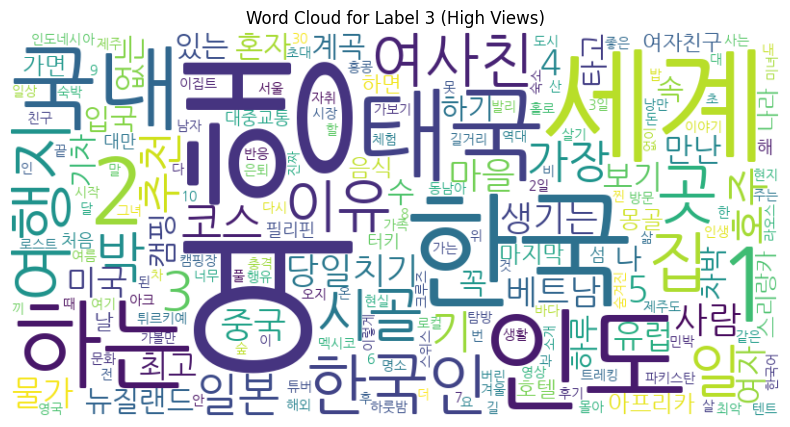

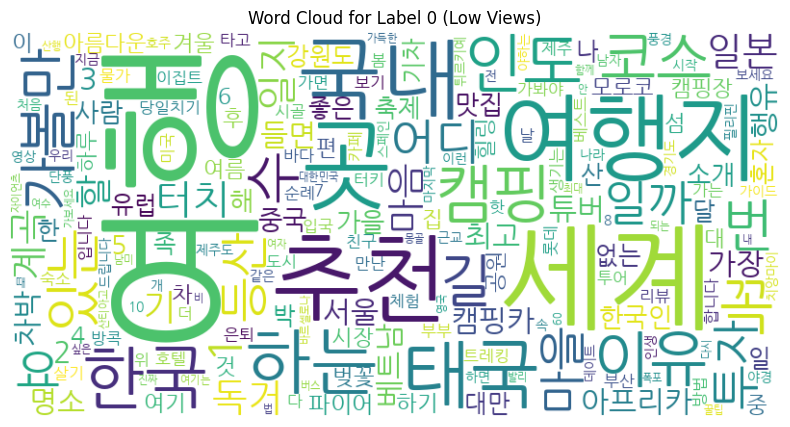

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# 한글 폰트 경로 설정
font_path = "/content/drive/MyDrive/NanumGothic.ttf"  # 한글 폰트 경로

# 데이터프레임에서 라벨별 데이터 추출
label_3_data = review[review['label'] == 3]['title']
label_0_data = review[review['label'] == 0]['title']

# 단어 빈도 계산 함수
def calculate_word_frequencies(text_data):
    vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
    word_counts = vectorizer.fit_transform(text_data)
    word_frequencies = word_counts.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    return dict(zip(words, word_frequencies))

# 라벨 5와 라벨 0의 단어 빈도 계산
label_3_frequencies = calculate_word_frequencies(label_3_data)
label_0_frequencies = calculate_word_frequencies(label_0_data)

# 워드 클라우드 생성 함수
def generate_wordcloud(word_frequencies, title):
    wordcloud = WordCloud(
        font_path=font_path,
        width=800,
        height=400,
        background_color='white'
    ).generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# 라벨 5의 워드 클라우드
generate_wordcloud(label_3_frequencies, "Word Cloud for Label 3 (High Views)")

# 라벨 0의 워드 클라우드
generate_wordcloud(label_0_frequencies, "Word Cloud for Label 0 (Low Views)")
